## Tugas Besar 2 IF3270 Pembelajaran Mesin - Bagian CNN

Notebook ini akan mengimplementasikan dan mengevaluasi Convolutional Neural Networks (CNN)
untuk klasifikasi gambar pada dataset CIFAR-10.

### **Tujuan Utama:**
1. Melatih model CNN menggunakan Keras dan dataset CIFAR-10, memenuhi ketentuan spesifik.
2. Melakukan analisis pengaruh berbagai hyperparameter terhadap kinerja CNN.
3. Mengimplementasikan modul forward propagation CNN from scratch secara modular.
4. Memvalidasi implementasi from scratch dengan membandingkan hasilnya (macro f1-score) dengan output Keras pada data test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import time
import os
import sys

ModuleNotFoundError: No module named 'sklearn'

In [2]:
current_notebook_path = os.getcwd()
project_root_path = os.path.abspath(
    os.path.join(current_notebook_path, os.pardir))
src_path = os.path.join(project_root_path, 'src')

if src_path not in sys.path:
    sys.path.insert(0, src_path)
    print(f"Direktori '{src_path}' telah ditambahkan ke sys.path")
else:
    print(f"Direktori '{src_path}' sudah ada di sys.path")

Direktori 'c:\coding\ML semester 6\Tubes-2-ML\src' telah ditambahkan ke sys.path


In [3]:
from data_loader import DataLoaderCIFAR10 
from keras_models import cnn_keras_model   

In [4]:
from CNN.conv_layer import Conv2DLayerFS
from CNN.activation_layer import ReLULayerFS
from CNN.pooling_layer import MaxPooling2DLayerFS, AveragePooling2DLayerFS
from CNN.flatten_layer import FlattenLayerFS      
from CNN.dense_layer import DenseLayerFS

In [5]:
try:
    # Dari src/models_from_scratch/cnn_fs.py
    from models_from_scratch.cnn_fs import CNNModelFS
except ImportError as e:
    print(f"ERROR: Tidak dapat mengimpor CNNModelFS. Pastikan file 'src/models_from_scratch/cnn_fs.py' ada dan kelas CNNModelFS terdefinisi.")
    print(f"Detail error: {e}")

In [6]:
# Membuat direktori untuk menyimpan model dan hasil (relatif terhadap lokasi eksekusi notebook)
models_save_dir = 'saved_models_cnn'  # Akan dibuat di dalam folder 'notebooks/'
# Akan dibuat di dalam folder 'notebooks/'
results_images_dir = 'results_images_cnn'

if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)
if not os.path.exists(results_images_dir):
    os.makedirs(results_images_dir)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Model akan disimpan di: {os.path.abspath(models_save_dir)}")
print(f"Gambar hasil akan disimpan di: {os.path.abspath(results_images_dir)}")


TensorFlow version: 2.19.0
NumPy version: 2.1.3
Model akan disimpan di: c:\coding\ML semester 6\Tubes-2-ML\notebooks\saved_models_cnn
Gambar hasil akan disimpan di: c:\coding\ML semester 6\Tubes-2-ML\notebooks\results_images_cnn


## SECTION 1: Persiapan Data CIFAR-10

Memuat dataset CIFAR-10 menggunakan `DataLoaderCIFAR10`. Dataset akan dibagi menjadi training (40k), validation (10k), dan test (10k).

In [7]:
cifar_loader = DataLoaderCIFAR10(random_state_split=42)

train_images, train_labels = cifar_loader.get_train_data()
val_images, val_labels = cifar_loader.get_validation_data()
test_images, test_labels = cifar_loader.get_test_data()

input_shape = cifar_loader.get_input_shape()
num_classes = cifar_loader.num_classes
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
print(f"Training data: {train_images.shape}, {train_labels.shape}")
print(f"Validation data: {val_images.shape}, {val_labels.shape}")
print(f"Test data: {test_images.shape}, {test_labels.shape}")

CIFAR-10 dataset loaded and preprocessed:
Training images shape: (40000, 32, 32, 3)
Training labels shape: (40000, 1)
Validation images shape: (10000, 32, 32, 3)
Validation labels shape: (10000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Input shape: (32, 32, 3)
Number of classes: 10
Training data: (40000, 32, 32, 3), (40000, 1)
Validation data: (10000, 32, 32, 3), (10000, 1)
Test data: (10000, 32, 32, 3), (10000, 1)


## SECTION 2: Pelatihan Model CNN dengan Keras dan Analisis Hyperparameter

Model minimal memiliki layer Conv2D, Pooling, Flatten/Global Pooling, dan Dense.
Loss function: Sparse Categorical Crossentropy. Optimizer: Adam.
Metrik perbandingan akhir: Macro F1-score.

In [8]:
def plot_training_history_local(history, model_name_title, save_path_prefix):
    plt.figure(figsize=(12, 5))
    plt.suptitle(model_name_title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_path_prefix:
        plt.savefig(os.path.join(results_images_dir,
                    f"{save_path_prefix}_history.png"))
    plt.show()


def evaluate_and_report_local(model, x_test, y_test, model_name="Model", class_names=None, save_path_prefix=None):
    print(f"\n--- Evaluation Report for: {model_name} ---")
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_proba = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
    print(f"Test Macro F1-Score: {macro_f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes,
          target_names=class_names if class_names else [f'Class {i}' for i in range(num_classes)]))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(
                    num_classes),
                yticklabels=class_names if class_names else np.arange(num_classes))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if save_path_prefix:
        plt.savefig(os.path.join(results_images_dir,
                    f"{save_path_prefix}_cm.png"))
    plt.show()
    return loss, accuracy, macro_f1

#### Global Training Parameter

In [9]:
EPOCHS = 30 
BATCH_SIZE = 64

### 2.1 Model Dasar (Baseline)
Digunakan sebagai acuan untuk eksperimen hyperparameter.

In [10]:
# Konfigurasi Model Dasar
from keras_models.cnn_keras_model import build_cnn_keras


baseline_conv_config = [
    {'filters': 32, 'kernel_size': (3, 3), 'num_conv_layers': 1},
    {'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1}
]
baseline_dense_config = [{'units': 128}]
baseline_pooling_type = 'max'
baseline_pooling_size = (2, 2)
baseline_use_global_pooling = None  # Artinya menggunakan Flatten

baseline_model_name = "CNN_Baseline"
baseline_model_path = os.path.join(
    models_save_dir, f"{baseline_model_name}_best.keras")

baseline_model = build_cnn_keras(
    input_shape=input_shape,
    num_classes=num_classes,
    conv_blocks_params=baseline_conv_config,
    pooling_type=baseline_pooling_type,
    pooling_size=baseline_pooling_size,
    use_global_pooling=baseline_use_global_pooling,
    dense_layers_params=baseline_dense_config
)
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Pelatihan Model Dasar
callbacks_baseline = [
    EarlyStopping(monitor='val_loss', patience=7,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint(baseline_model_path, save_best_only=True,
                    monitor='val_loss', verbose=1)
]

history_baseline = baseline_model.fit(
    train_images, train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels),
    callbacks=callbacks_baseline,
    verbose=1
)

Epoch 1/30
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3804 - loss: 1.7151
Epoch 1: val_loss improved from inf to 1.22827, saving model to saved_models_cnn\CNN_Baseline_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3812 - loss: 1.7131 - val_accuracy: 0.5679 - val_loss: 1.2283
Epoch 2/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6098 - loss: 1.1095
Epoch 2: val_loss improved from 1.22827 to 1.01264, saving model to saved_models_cnn\CNN_Baseline_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6098 - loss: 1.1095 - val_accuracy: 0.6536 - val_loss: 1.0126
Epoch 3/30
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6620 - loss: 0.9603
Epoch 3: val_loss improved from 1.01264 to 0.96770, saving model to saved_models_cnn\CNN_Baseline_best.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6620 - loss: 0.9603 - val_accuracy: 0.6659 - val_loss: 0.9677
Epoch 4/30
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accura

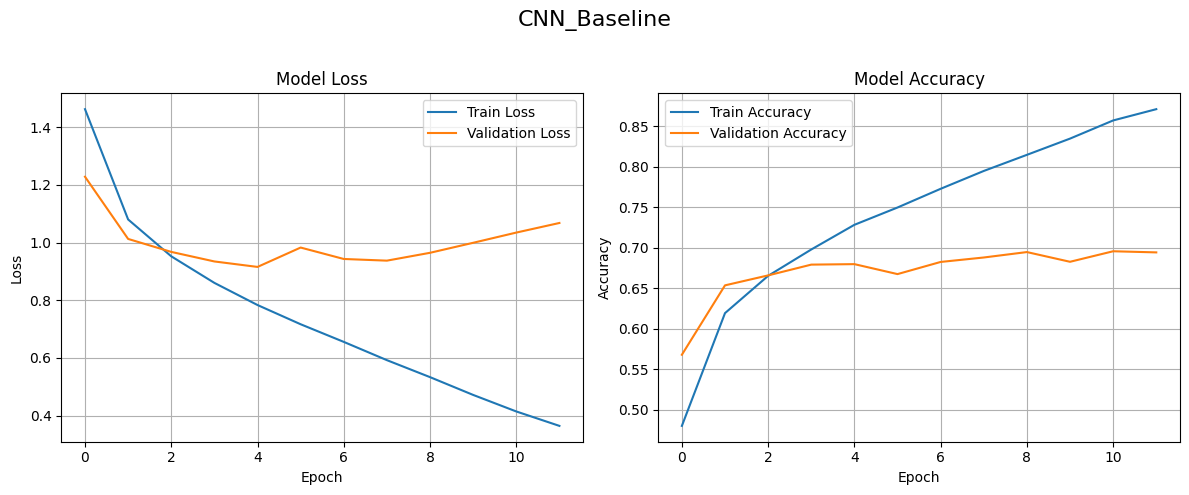


--- Evaluation Report for: CNN_Baseline ---
Test Loss: 0.9138
Test Accuracy: 0.6775
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.6787

Classification Report:
              precision    recall  f1-score   support

    airplane       0.77      0.68      0.72      1000
  automobile       0.85      0.77      0.81      1000
        bird       0.47      0.67      0.56      1000
         cat       0.48      0.52      0.50      1000
        deer       0.63      0.61      0.62      1000
         dog       0.71      0.46      0.55      1000
        frog       0.66      0.85      0.74      1000
       horse       0.83      0.65      0.73      1000
        ship       0.80      0.78      0.79      1000
       truck       0.74      0.80      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



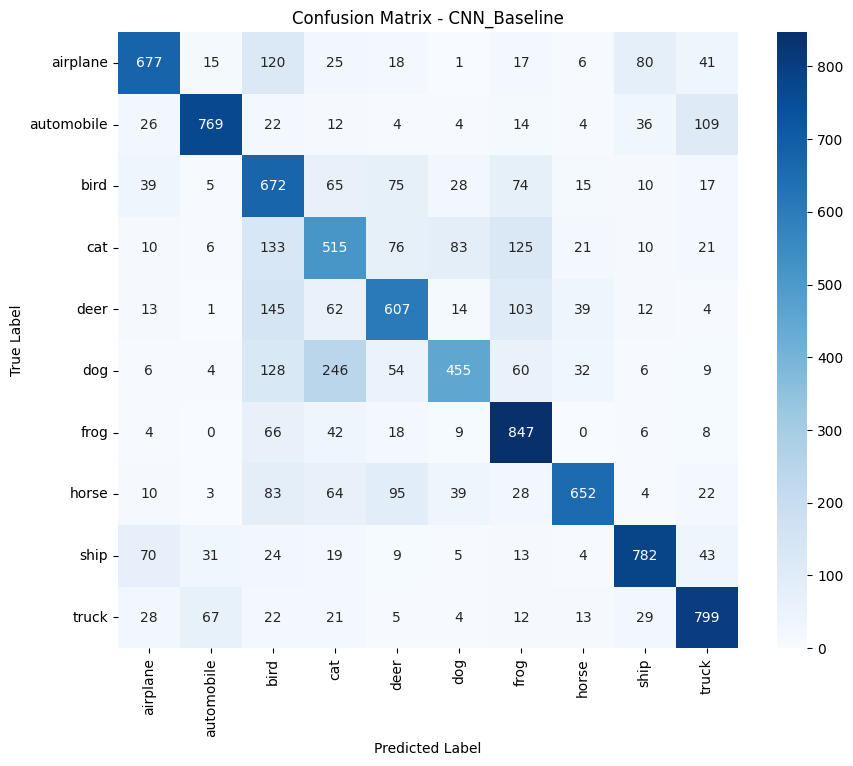

In [ ]:
# Evaluasi Model Dasar
baseline_model.load_weights(baseline_model_path)  # Muat bobot terbaik
plot_training_history_local(
    history_baseline, baseline_model_name, baseline_model_name)
loss_base, acc_base, f1_base = evaluate_and_report_local(
    baseline_model, test_images, test_labels, baseline_model_name, cifar10_class_names, baseline_model_name)

In [14]:
# Variabel ini akan digunakan untuk perbandingan dengan model from scratch nanti
best_keras_model_for_fs_path = baseline_model_path

### 2.2 Eksperimen Hyperparameter

Fungsi untuk menjalankan set eksperimen dan menyimpan hasilnya.

In [11]:
def run_cnn_experiment(experiment_group_name, variations_dict, base_params_dict, param_to_vary_in_build_fn):
    all_experiment_results = {}
    all_histories_val_loss = {}

    print(f"\n\n{'='*20} Mulai Eksperimen: {experiment_group_name} {'='*20}")

    for var_name, var_value in variations_dict.items():
        current_model_name_slug = f"{experiment_group_name.replace(' ', '_')}_{var_name.replace(' ', '_')}"
        current_model_display_name = f"{experiment_group_name} - {var_name}"
        print(f"\n--- Melatih: {current_model_display_name} ---")

        current_build_params = base_params_dict.copy()
        current_build_params[param_to_vary_in_build_fn] = var_value

        model_exp = build_cnn_keras(
            input_shape=input_shape,
            num_classes=num_classes,
            **current_build_params
        )

        model_exp_path = os.path.join(
            models_save_dir, f"{current_model_name_slug}_best.keras")
        callbacks_exp = [
            # Patience lebih pendek untuk eksperimen
            EarlyStopping(monitor='val_loss', patience=5,
                          restore_best_weights=True, verbose=1),
            ModelCheckpoint(model_exp_path, save_best_only=True,
                            monitor='val_loss', verbose=0)
        ]

        history_exp = model_exp.fit(
            train_images, train_labels,
            # Pertimbangkan epoch lebih pendek untuk eksperimen
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            validation_data=(val_images, val_labels),
            callbacks=callbacks_exp, verbose=0
        )
        print(f"Selesai melatih {current_model_display_name}.")

        model_exp.load_weights(model_exp_path)
        plot_training_history_local(
            history_exp, current_model_display_name, current_model_name_slug)
        loss, acc, f1 = evaluate_and_report_local(
            model_exp, test_images, test_labels, current_model_display_name, cifar10_class_names, current_model_name_slug)

        all_experiment_results[current_model_display_name] = {
            'loss': loss, 'accuracy': acc, 'f1_score': f1, 'model_path': model_exp_path}
        all_histories_val_loss[current_model_display_name] = history_exp.history['val_loss']
        tf.keras.backend.clear_session()

    # Plot perbandingan validation loss untuk grup eksperimen ini
    plt.figure(figsize=(12, 7))
    for name, val_loss_hist in all_histories_val_loss.items():
        plt.plot(val_loss_hist, label=name)  # Label sudah termasuk nama grup
    plt.title(f'Perbandingan Validation Loss - {experiment_group_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend(loc='best')  # Biarkan matplotlib memilih lokasi terbaik
    plt.grid(True)
    # plt.tight_layout() # Mungkin tidak perlu jika legenda di 'best'
    plt.savefig(os.path.join(results_images_dir,
                f"{experiment_group_name.replace(' ', '_')}_val_loss_comparison.png"))
    plt.show()

    print(f"\n--- Hasil Akhir untuk Eksperimen: {experiment_group_name} ---")
    for name, metrics in all_experiment_results.items():
        print(
            f"{name}: Macro F1-Score = {metrics['f1_score']:.4f}, Accuracy = {metrics['accuracy']:.4f}")
    return all_experiment_results

#### 2.2.1 Pengaruh Jumlah Layer Konvolusi
Pilih 3 variasi.



==================== Mulai Eksperimen: Pengaruh Jumlah Layer Konvolusi ====================

--- Melatih: Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv ---
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
Selesai melatih Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv.


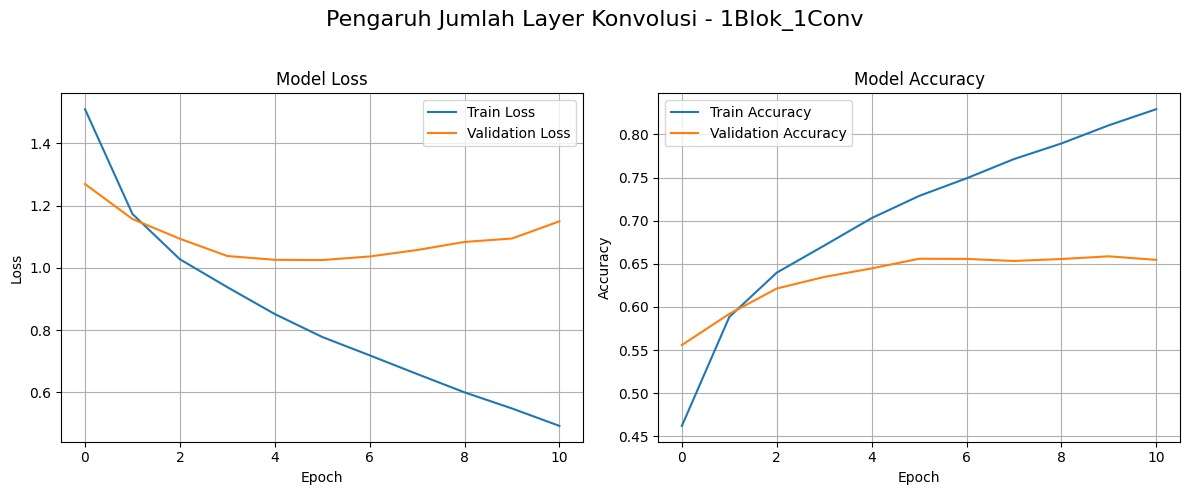


--- Evaluation Report for: Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv ---
Test Loss: 1.0415
Test Accuracy: 0.6411
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.6390

Classification Report:
              precision    recall  f1-score   support

    airplane       0.65      0.73      0.69      1000
  automobile       0.71      0.81      0.76      1000
        bird       0.48      0.53      0.51      1000
         cat       0.43      0.54      0.48      1000
        deer       0.64      0.53      0.58      1000
         dog       0.65      0.38      0.48      1000
        frog       0.69      0.77      0.73      1000
       horse       0.77      0.67      0.71      1000
        ship       0.75      0.75      0.75      1000
       truck       0.72      0.70      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



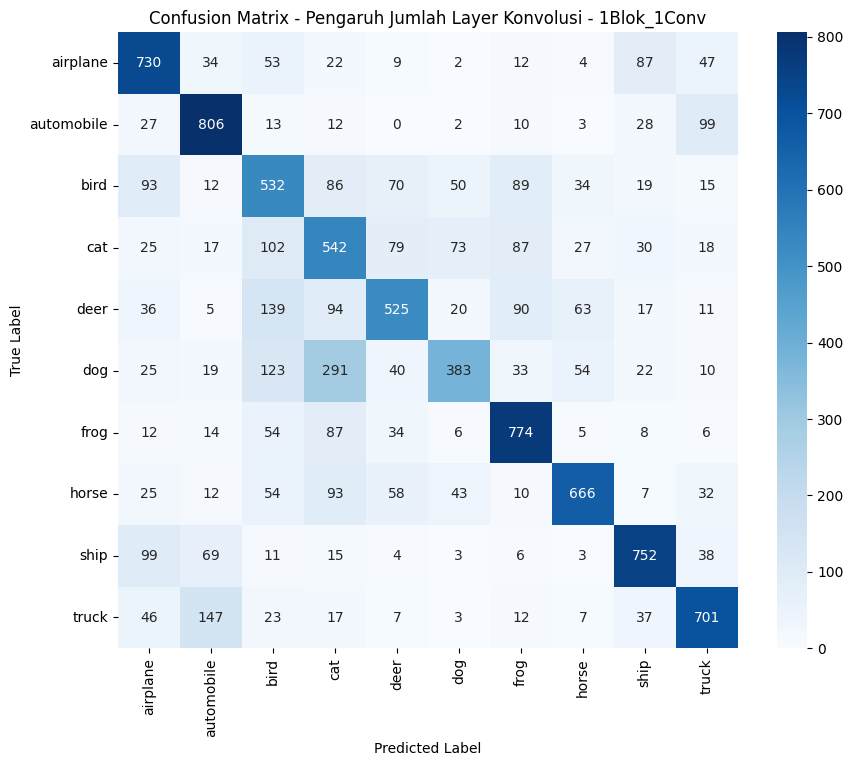



--- Melatih: Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer.


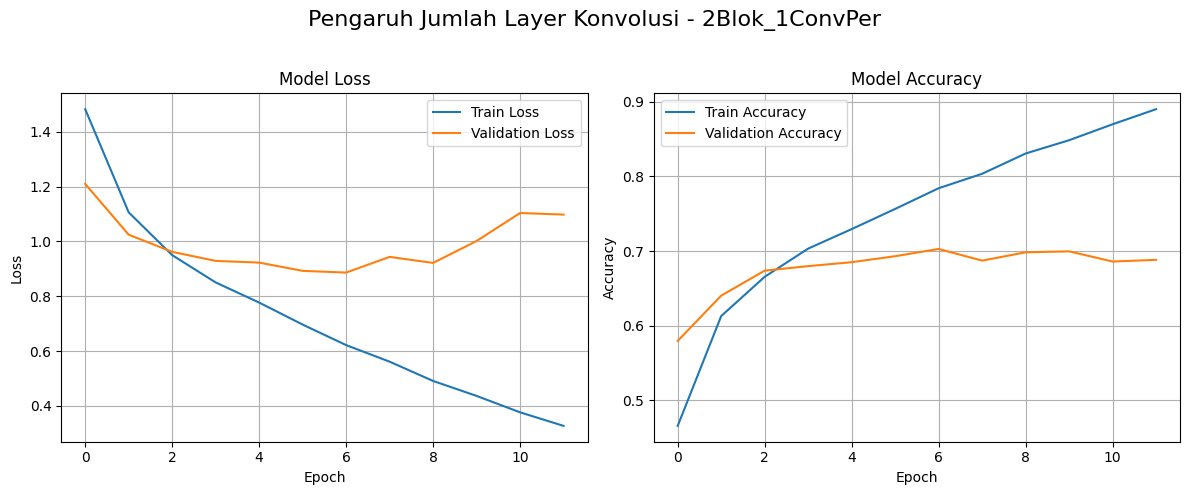


--- Evaluation Report for: Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer ---
Test Loss: 0.8758
Test Accuracy: 0.7059
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.7014

Classification Report:
              precision    recall  f1-score   support

    airplane       0.75      0.72      0.74      1000
  automobile       0.79      0.84      0.81      1000
        bird       0.65      0.54      0.59      1000
         cat       0.60      0.44      0.50      1000
        deer       0.61      0.74      0.67      1000
         dog       0.62      0.61      0.62      1000
        frog       0.69      0.84      0.76      1000
       horse       0.81      0.72      0.76      1000
        ship       0.74      0.86      0.80      1000
       truck       0.79      0.75      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000



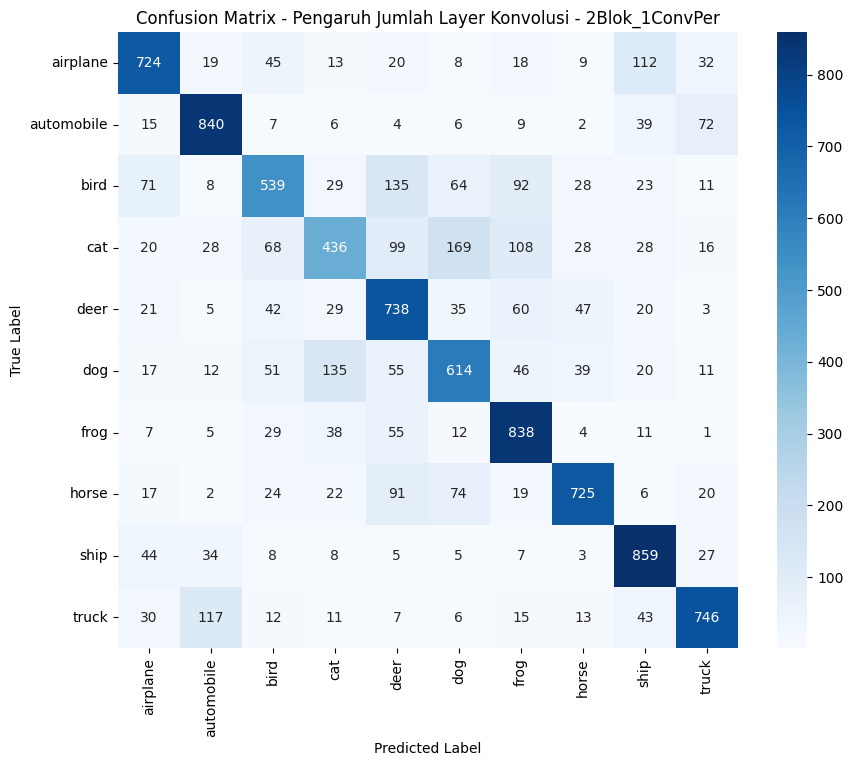


--- Melatih: Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer.


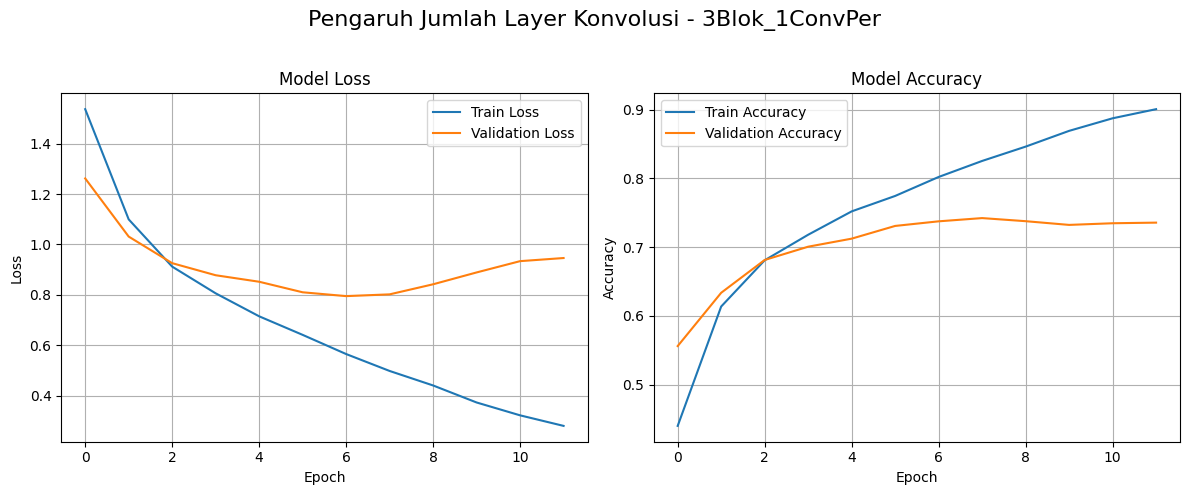


--- Evaluation Report for: Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer ---
Test Loss: 0.8176
Test Accuracy: 0.7308
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Macro F1-Score: 0.7290

Classification Report:
              precision    recall  f1-score   support

    airplane       0.67      0.84      0.75      1000
  automobile       0.83      0.84      0.84      1000
        bird       0.72      0.54      0.62      1000
         cat       0.54      0.58      0.56      1000
        deer       0.66      0.70      0.68      1000
         dog       0.71      0.57      0.63      1000
        frog       0.82      0.79      0.80      1000
       horse       0.74      0.81      0.77      1000
        ship       0.86      0.80      0.83      1000
       truck       0.79      0.84      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



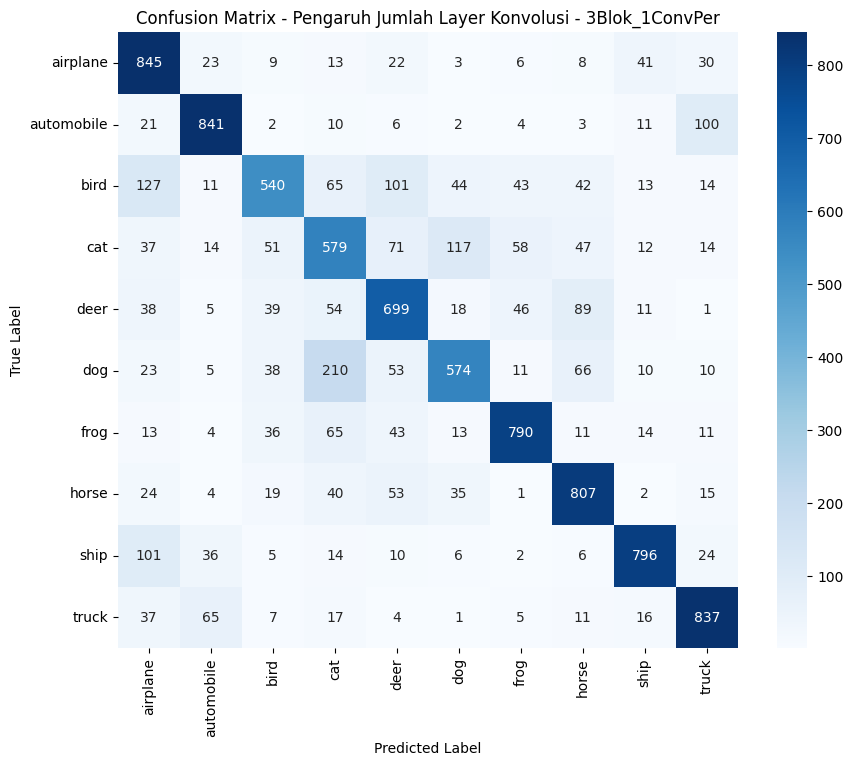

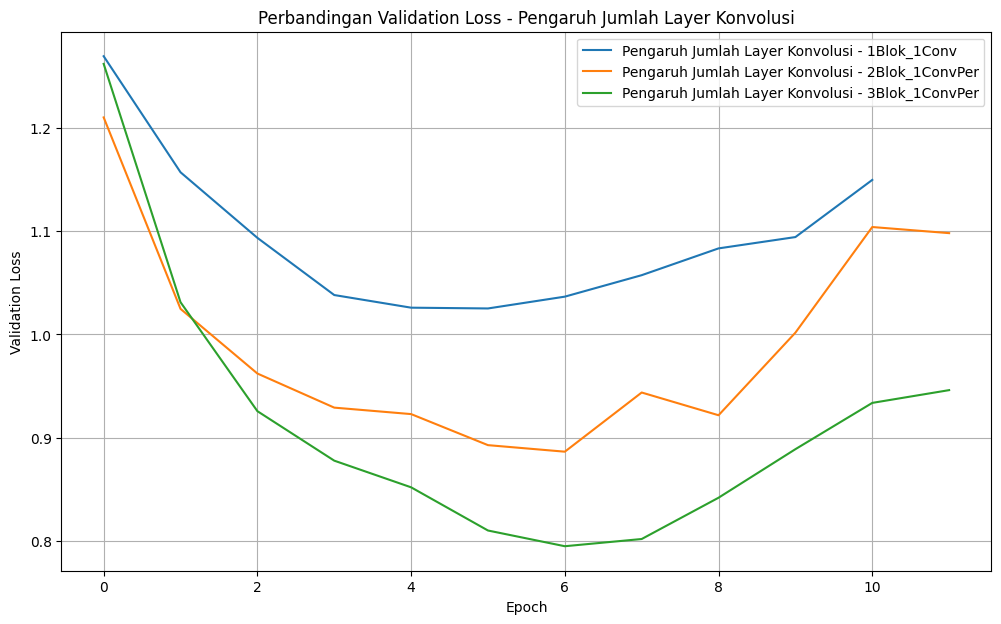


--- Hasil Akhir untuk Eksperimen: Pengaruh Jumlah Layer Konvolusi ---
Pengaruh Jumlah Layer Konvolusi - 1Blok_1Conv: Macro F1-Score = 0.6390, Accuracy = 0.6411
Pengaruh Jumlah Layer Konvolusi - 2Blok_1ConvPer: Macro F1-Score = 0.7014, Accuracy = 0.7059
Pengaruh Jumlah Layer Konvolusi - 3Blok_1ConvPer: Macro F1-Score = 0.7290, Accuracy = 0.7308


In [14]:
base_params_for_exp = {
    'pooling_type': baseline_pooling_type,
    'pooling_size': baseline_pooling_size,
    'use_global_pooling': baseline_use_global_pooling,
    'dense_layers_params': baseline_dense_config
}

conv_layer_variations = {
    "1Blok_1Conv": [{'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1}],
    "2Blok_1ConvPer": baseline_conv_config,  # Baseline
    "3Blok_1ConvPer": [
        {'filters': 32, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 128, 'kernel_size': (3, 3), 'num_conv_layers': 1}
    ]
}
results_num_conv_layers = run_cnn_experiment(
    "Pengaruh Jumlah Layer Konvolusi",
    conv_layer_variations,
    base_params_for_exp,
    'conv_blocks_params'
)

**Kesimpulan Pengaruh Jumlah Layer Konvolusi:**

Berdasarkan hasil eksperimen dengan 3 variasi jumlah layer konvolusi:

- **1 Blok (1 Conv)**: Model dengan arsitektur paling sederhana menunjukkan performa terendah dengan indikasi underfitting. Validation loss tetap tinggi dan tidak konvergen dengan baik, menunjukkan bahwa model terlalu sederhana untuk menangkap kompleksitas data CIFAR-10.

- **2 Blok (Baseline)**: Memberikan keseimbangan yang baik antara kompleksitas model dan kemampuan generalisasi. Validation loss konvergen dengan stabil tanpa overfitting yang signifikan.

- **3 Blok (1 Conv per blok)**: Menunjukkan performa terbaik dengan F1-score tertinggi. Model yang lebih dalam mampu menangkap hierarki fitur yang lebih kompleks - dari edge detection di layer awal hingga pattern recognition yang lebih abstrak di layer yang lebih dalam.

**Temuan Utama**: Menambah kedalaman network (dari 1 ke 3 blok konvolusi) secara konsisten meningkatkan performa klasifikasi. Arsitektur yang lebih dalam memungkinkan ekstraksi fitur hierarkis yang lebih baik untuk dataset kompleks seperti CIFAR-10, namun perlu diimbangi dengan regularisasi yang tepat untuk mencegah overfitting.

#### 2.2.2 Pengaruh Banyak Filter per Layer Konvolusi
Pilih 3 variasi. (Struktur blok konvolusi tetap seperti baseline: 2 blok, 1 conv per blok)



==================== Mulai Eksperimen: Pengaruh Banyak Filter ====================

--- Melatih: Pengaruh Banyak Filter - FilterKecil_16_32 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Banyak Filter - FilterKecil_16_32.


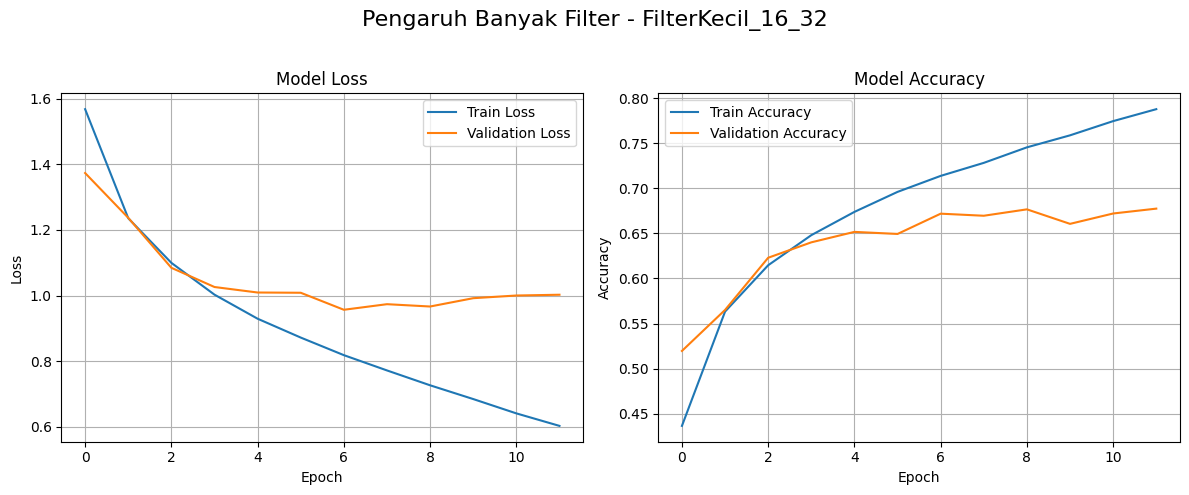


--- Evaluation Report for: Pengaruh Banyak Filter - FilterKecil_16_32 ---
Test Loss: 0.9521
Test Accuracy: 0.6748
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6724

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.69      0.71      1000
  automobile       0.71      0.84      0.77      1000
        bird       0.50      0.64      0.56      1000
         cat       0.56      0.40      0.47      1000
        deer       0.64      0.59      0.62      1000
         dog       0.58      0.61      0.60      1000
        frog       0.77      0.76      0.76      1000
       horse       0.74      0.74      0.74      1000
        ship       0.76      0.81      0.78      1000
       truck       0.77      0.67      0.72      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000



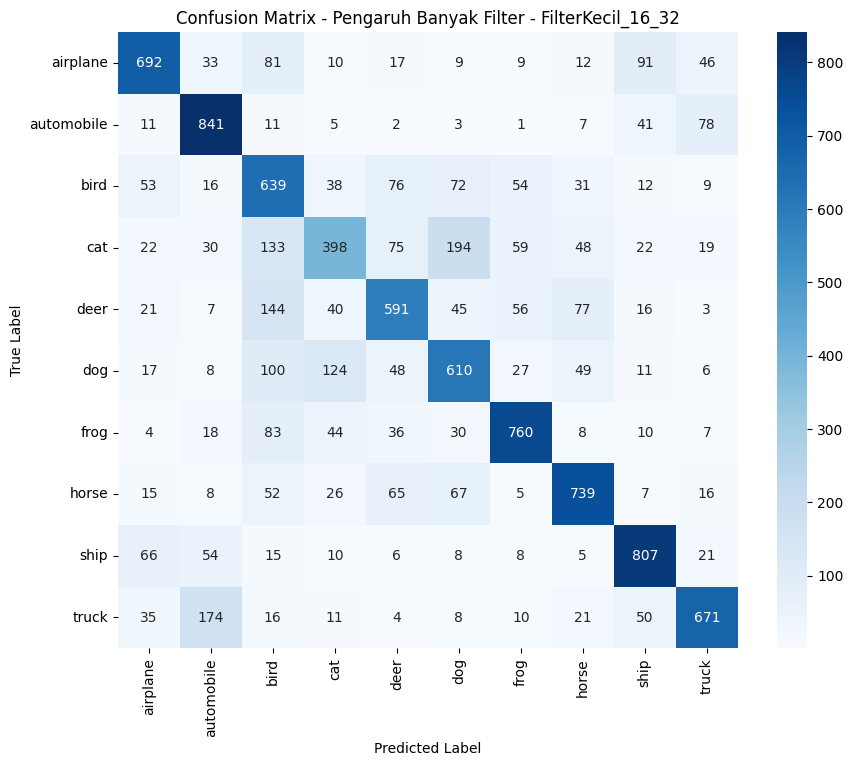


--- Melatih: Pengaruh Banyak Filter - FilterSedang_32_64 ---
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
Selesai melatih Pengaruh Banyak Filter - FilterSedang_32_64.


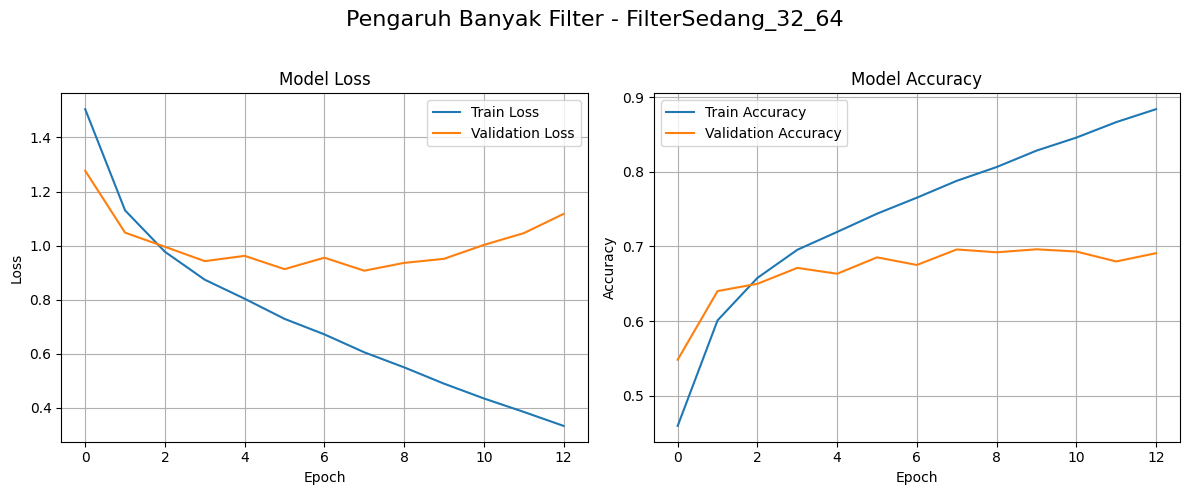


--- Evaluation Report for: Pengaruh Banyak Filter - FilterSedang_32_64 ---
Test Loss: 0.8973
Test Accuracy: 0.7035
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.7041

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.79      0.74      1000
  automobile       0.80      0.79      0.79      1000
        bird       0.56      0.62      0.59      1000
         cat       0.54      0.54      0.54      1000
        deer       0.69      0.64      0.67      1000
         dog       0.64      0.60      0.62      1000
        frog       0.72      0.84      0.77      1000
       horse       0.75      0.78      0.77      1000
        ship       0.92      0.69      0.79      1000
       truck       0.78      0.75      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



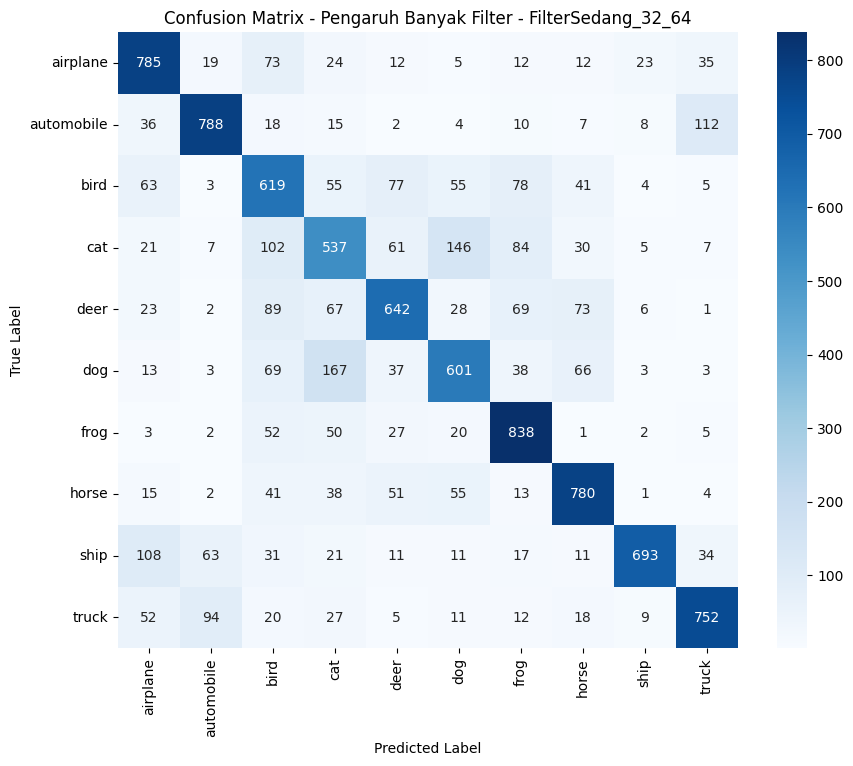


--- Melatih: Pengaruh Banyak Filter - FilterBesar_64_128 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Banyak Filter - FilterBesar_64_128.


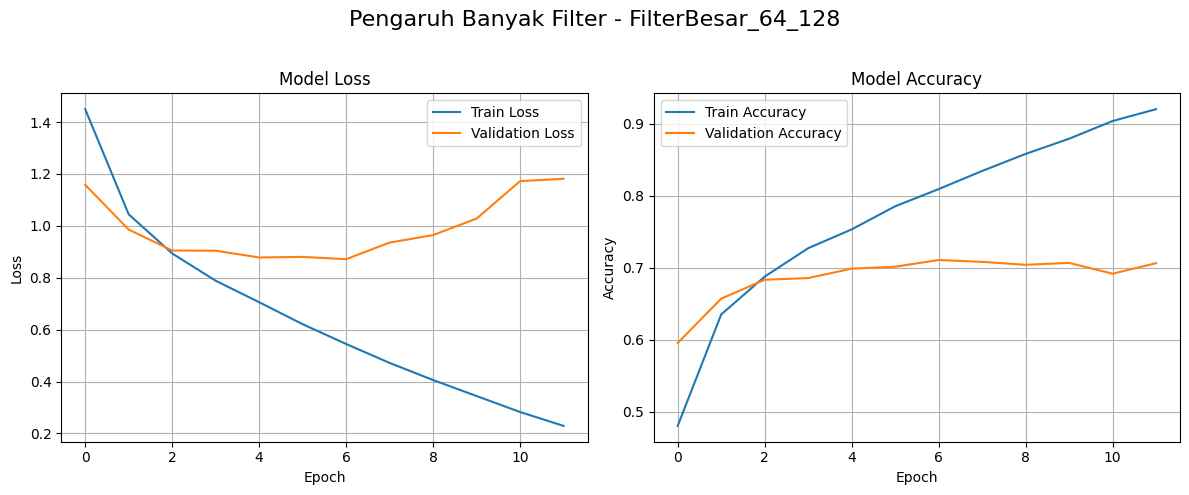


--- Evaluation Report for: Pengaruh Banyak Filter - FilterBesar_64_128 ---
Test Loss: 0.8809
Test Accuracy: 0.7086
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Test Macro F1-Score: 0.7107

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.74      0.74      1000
  automobile       0.86      0.77      0.81      1000
        bird       0.62      0.62      0.62      1000
         cat       0.47      0.59      0.52      1000
        deer       0.68      0.65      0.67      1000
         dog       0.64      0.56      0.60      1000
        frog       0.76      0.76      0.76      1000
       horse       0.83      0.71      0.77      1000
        ship       0.80      0.84      0.82      1000
       truck       0.77      0.83      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



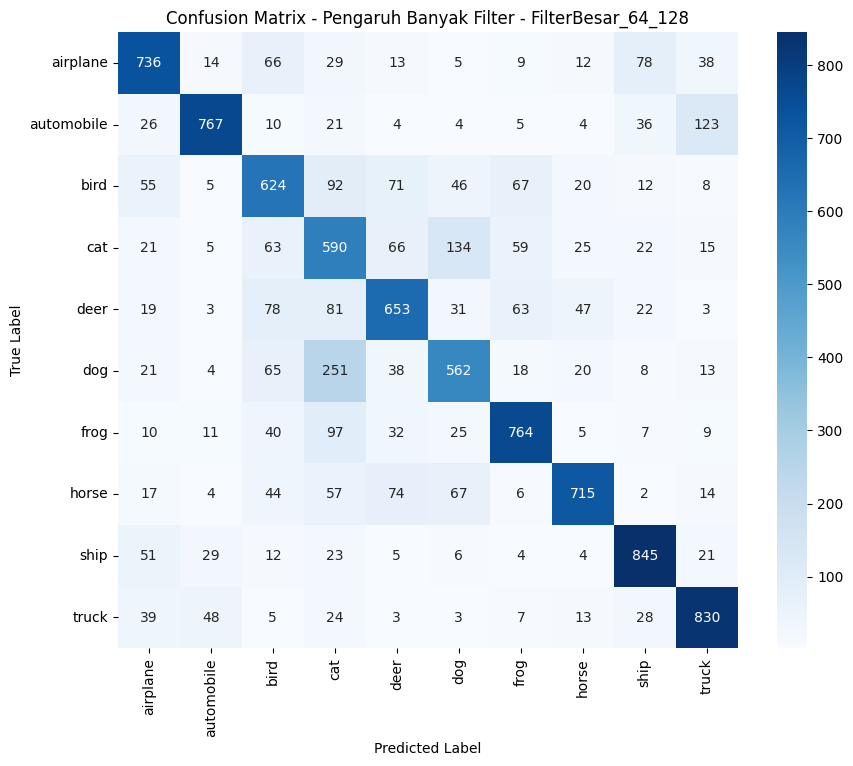

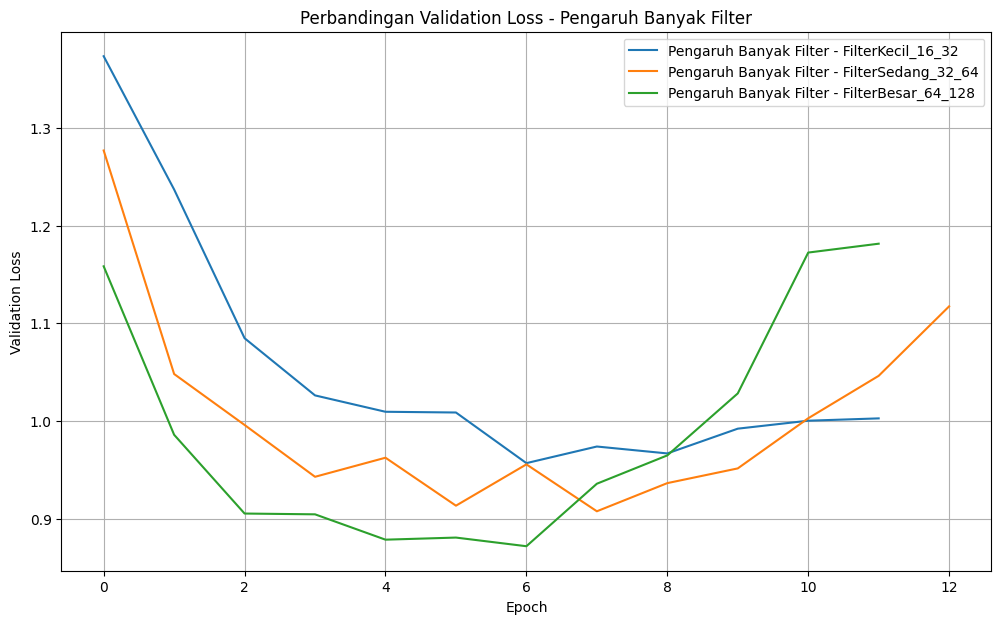


--- Hasil Akhir untuk Eksperimen: Pengaruh Banyak Filter ---
Pengaruh Banyak Filter - FilterKecil_16_32: Macro F1-Score = 0.6724, Accuracy = 0.6748
Pengaruh Banyak Filter - FilterSedang_32_64: Macro F1-Score = 0.7041, Accuracy = 0.7035
Pengaruh Banyak Filter - FilterBesar_64_128: Macro F1-Score = 0.7107, Accuracy = 0.7086


In [15]:
num_filter_variations = {
    "FilterKecil_16_32": [
        {'filters': 16, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 32, 'kernel_size': (3, 3), 'num_conv_layers': 1}
    ],
    "FilterSedang_32_64": baseline_conv_config,  # Baseline
    "FilterBesar_64_128": [
        {'filters': 64, 'kernel_size': (3, 3), 'num_conv_layers': 1},
        {'filters': 128, 'kernel_size': (3, 3), 'num_conv_layers': 1}
    ]
}
results_num_filters = run_cnn_experiment(
    "Pengaruh Banyak Filter",
    num_filter_variations,
    base_params_for_exp,  # Menggunakan base_params_for_exp yang sama
    'conv_blocks_params'
)

**Kesimpulan Pengaruh Banyak Filter:**

Hasil eksperimen dengan 3 variasi jumlah filter menunjukkan:

- **Filter Kecil (16-32)**: Performa terendah karena kapasitas representasi yang terbatas. Model tidak mampu menangkap keragaman fitur yang cukup untuk membedakan 10 kelas CIFAR-10 secara optimal.

- **Filter Sedang (32-64, Baseline)**: Memberikan keseimbangan yang baik antara kapasitas model dan efisiensi komputasi. Validation loss menunjukkan konvergensi yang stabil.

- **Filter Besar (64-128)**: Mencapai performa terbaik dengan peningkatan marginal namun konsisten. Lebih banyak filter memungkinkan deteksi pattern yang lebih beragam dan spesifik.

**Temuan Utama**: Peningkatan jumlah filter memberikan improvement yang konsisten tetapi dengan diminishing returns. Setiap penambahan filter meningkatkan kapasitas model untuk mendeteksi fitur yang lebih beragam, namun peningkatan performa tidak sebesar penambahan layer konvolusi. Trade-off antara performa dan kompleksitas komputasi perlu dipertimbangkan dalam pemilihan jumlah filter optimal.

#### 2.2.3 Pengaruh Ukuran Filter per Layer Konvolusi
Pilih 3 variasi. (Struktur blok dan jumlah filter tetap seperti baseline)



==================== Mulai Eksperimen: Pengaruh Ukuran Filter ====================

--- Melatih: Pengaruh Ukuran Filter - Kernel_2x2 ---
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
Selesai melatih Pengaruh Ukuran Filter - Kernel_2x2.


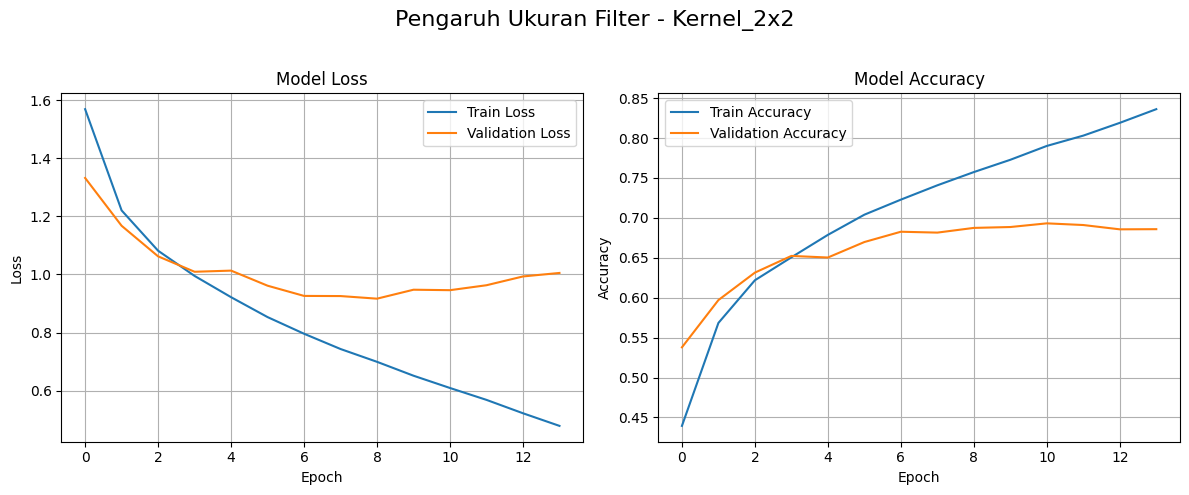


--- Evaluation Report for: Pengaruh Ukuran Filter - Kernel_2x2 ---
Test Loss: 0.9168
Test Accuracy: 0.6837
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Macro F1-Score: 0.6821

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.70      0.70      1000
  automobile       0.80      0.78      0.79      1000
        bird       0.54      0.60      0.57      1000
         cat       0.56      0.44      0.49      1000
        deer       0.68      0.57      0.62      1000
         dog       0.55      0.66      0.60      1000
        frog       0.80      0.70      0.75      1000
       horse       0.72      0.79      0.75      1000
        ship       0.75      0.83      0.79      1000
       truck       0.77      0.77      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



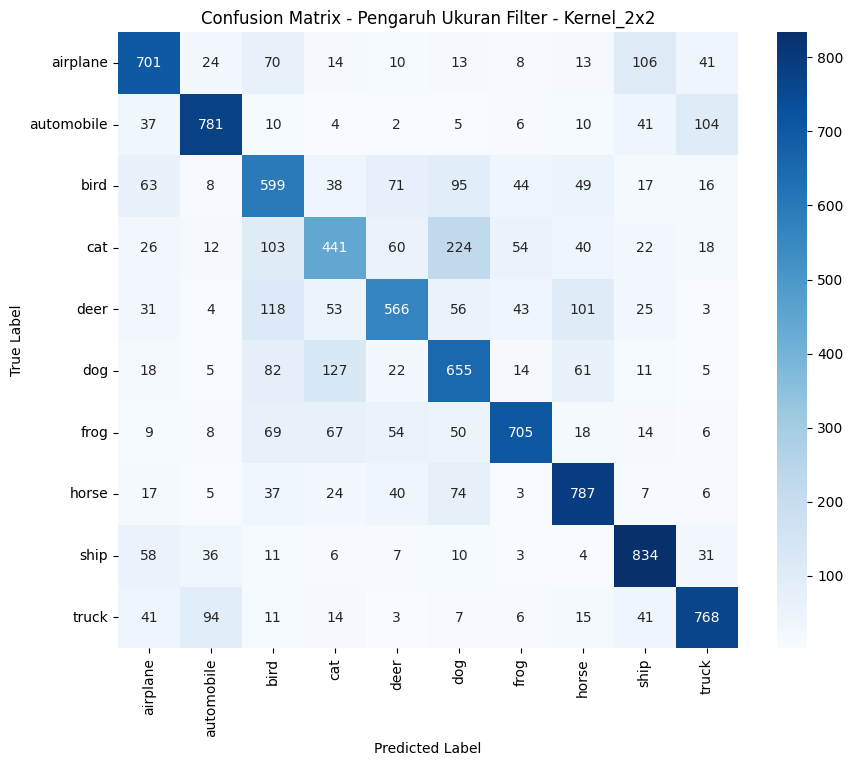


--- Melatih: Pengaruh Ukuran Filter - Kernel_3x3 ---
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
Selesai melatih Pengaruh Ukuran Filter - Kernel_3x3.


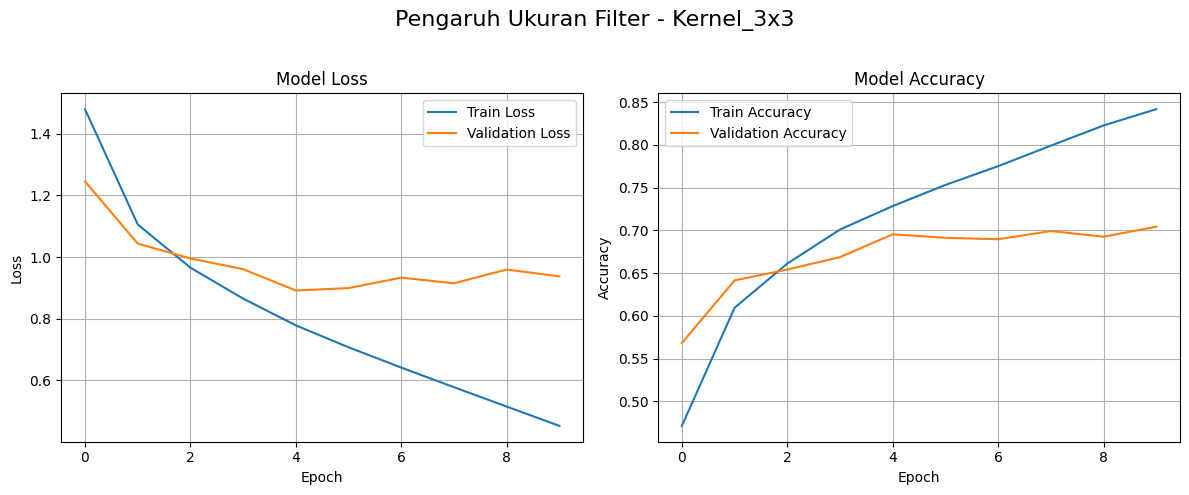


--- Evaluation Report for: Pengaruh Ukuran Filter - Kernel_3x3 ---
Test Loss: 0.8923
Test Accuracy: 0.6917
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.6915

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.68      0.71      1000
  automobile       0.77      0.81      0.79      1000
        bird       0.63      0.53      0.58      1000
         cat       0.47      0.59      0.53      1000
        deer       0.64      0.65      0.65      1000
         dog       0.65      0.54      0.59      1000
        frog       0.79      0.76      0.78      1000
       horse       0.78      0.72      0.75      1000
        ship       0.73      0.85      0.79      1000
       truck       0.74      0.77      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



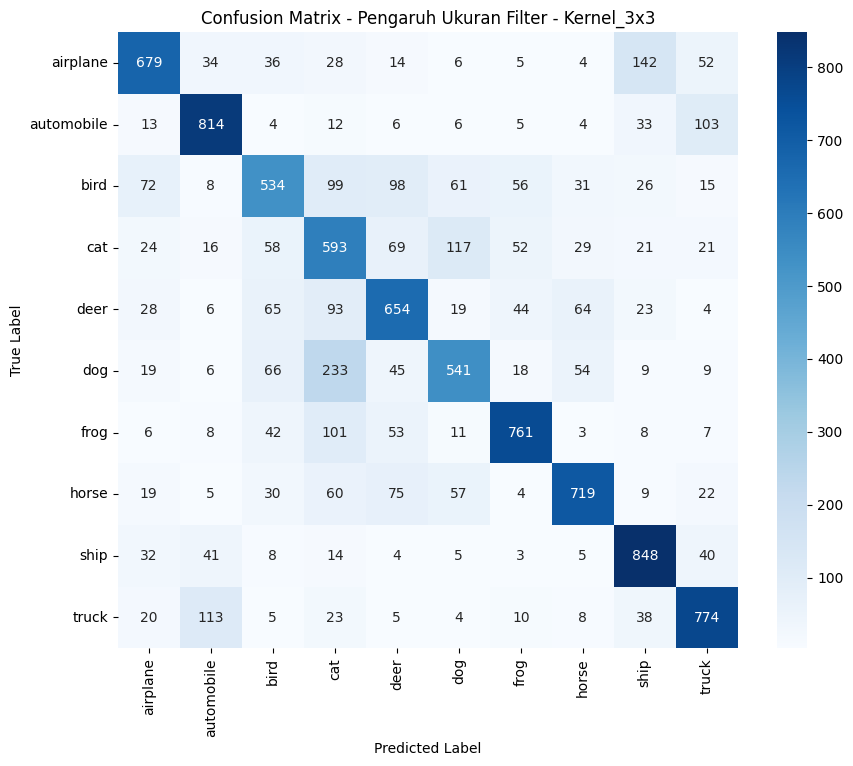


--- Melatih: Pengaruh Ukuran Filter - Kernel_5x5 ---
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
Selesai melatih Pengaruh Ukuran Filter - Kernel_5x5.


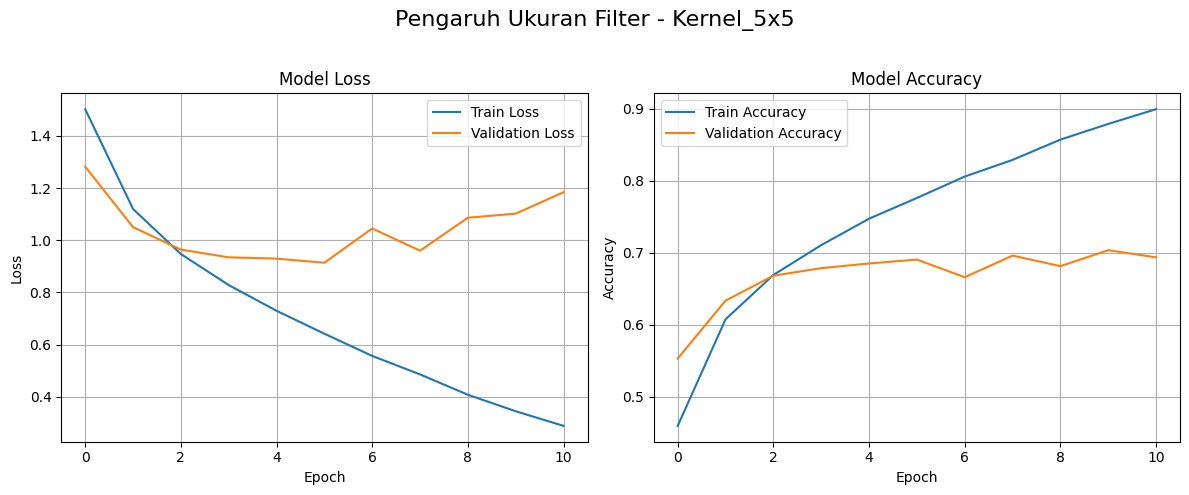


--- Evaluation Report for: Pengaruh Ukuran Filter - Kernel_5x5 ---
Test Loss: 0.9132
Test Accuracy: 0.6900
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Macro F1-Score: 0.6859

Classification Report:
              precision    recall  f1-score   support

    airplane       0.75      0.72      0.74      1000
  automobile       0.84      0.77      0.80      1000
        bird       0.65      0.52      0.57      1000
         cat       0.55      0.42      0.48      1000
        deer       0.63      0.61      0.62      1000
         dog       0.59      0.63      0.61      1000
        frog       0.69      0.80      0.74      1000
       horse       0.71      0.79      0.74      1000
        ship       0.82      0.81      0.81      1000
       truck       0.67      0.84      0.75      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



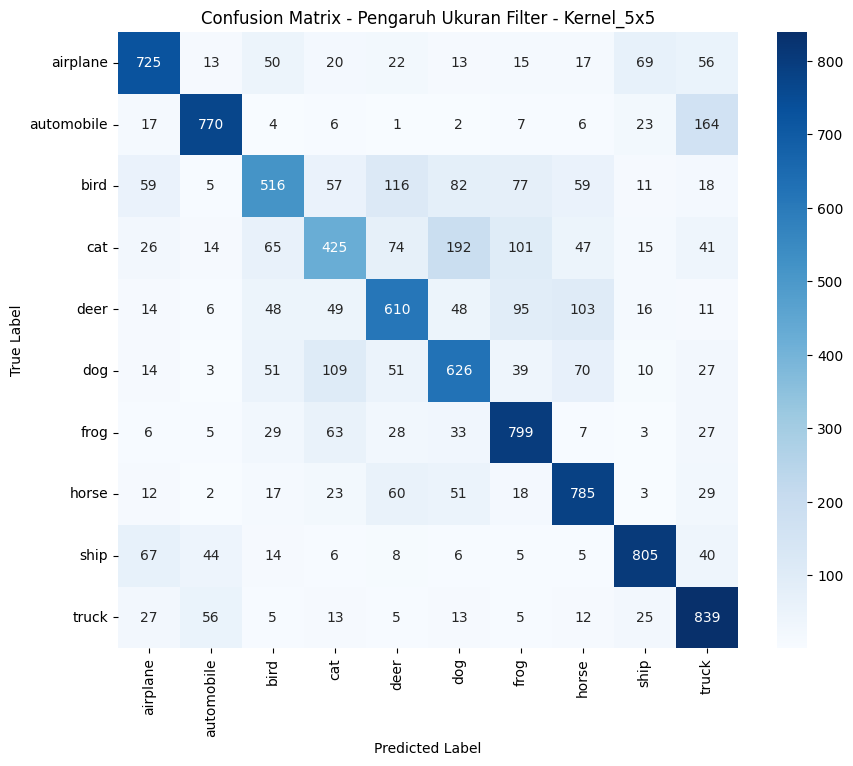

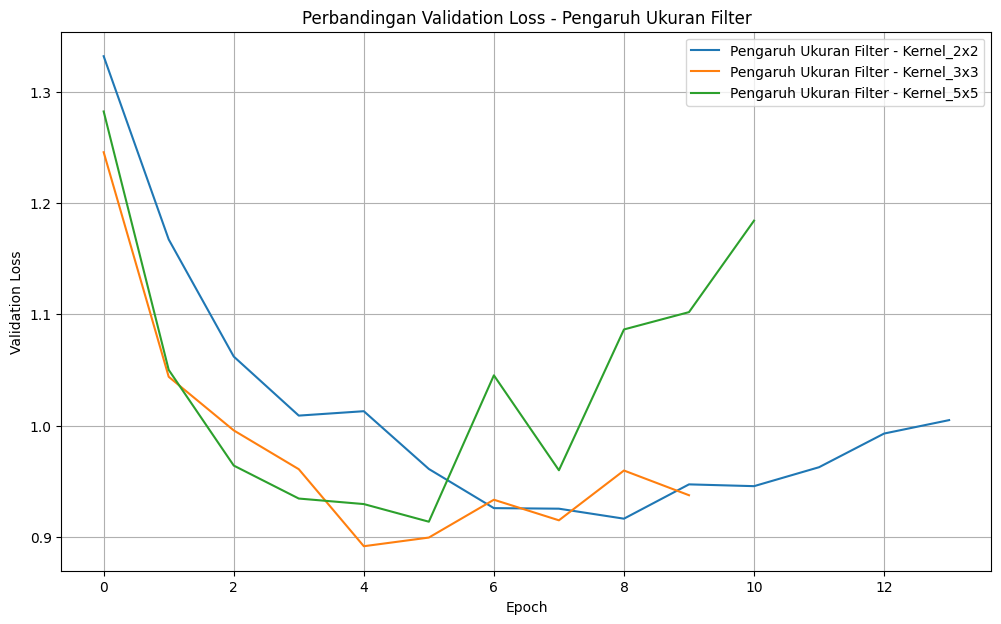


--- Hasil Akhir untuk Eksperimen: Pengaruh Ukuran Filter ---
Pengaruh Ukuran Filter - Kernel_2x2: Macro F1-Score = 0.6821, Accuracy = 0.6837
Pengaruh Ukuran Filter - Kernel_3x3: Macro F1-Score = 0.6915, Accuracy = 0.6917
Pengaruh Ukuran Filter - Kernel_5x5: Macro F1-Score = 0.6859, Accuracy = 0.6900


In [16]:
def generate_conv_config_with_new_kernel(base_conv_conf, new_kernel_size):
    new_conf = []
    for block in base_conv_conf:  # base_conv_conf di sini adalah list dari dict
        modified_block = block.copy()
        modified_block['kernel_size'] = new_kernel_size
        new_conf.append(modified_block)
    return new_conf


kernel_size_variations_configs = {
    "Kernel_2x2": generate_conv_config_with_new_kernel(baseline_conv_config, (2, 2)),
    "Kernel_3x3": baseline_conv_config,  # Baseline
    "Kernel_5x5": generate_conv_config_with_new_kernel(baseline_conv_config, (5, 5)),
}

results_kernel_size = run_cnn_experiment(
    "Pengaruh Ukuran Filter",
    kernel_size_variations_configs,
    # Base params tidak termasuk conv_blocks_params di sini karena di-override
    base_params_for_exp,
    'conv_blocks_params'
)

**Kesimpulan Pengaruh Ukuran Filter:**

Eksperimen dengan 3 variasi ukuran kernel menghasilkan insights berikut:

- **Kernel 2x2**: Performa di bawah baseline karena receptive field yang terlalu kecil. Filter 2x2 hanya dapat menangkap fitur lokal yang sangat terbatas, kurang efektif untuk objek dengan struktur spasial yang kompleks di CIFAR-10.

- **Kernel 3x3 (Baseline)**: Memberikan performa optimal dengan keseimbangan terbaik antara receptive field dan efisiensi parameter. Ukuran 3x3 cukup untuk menangkap edge, corner, dan tekstur dasar yang penting untuk klasifikasi.

- **Kernel 5x5**: Performa sedikit menurun meskipun memiliki receptive field lebih besar. Kernel yang lebih besar dapat menangkap konteks spasial yang lebih luas tetapi juga lebih rentan terhadap noise dan membutuhkan lebih banyak parameter.

**Temuan Utama**: Kernel 3x3 terbukti optimal untuk CIFAR-10, sejalan dengan best practice dalam arsitektur CNN modern. Ukuran ini memberikan trade-off terbaik antara kemampuan deteksi fitur spasial dan efisiensi parameter. Kernel yang terlalu kecil (2x2) membatasi kapasitas representasi, sementara kernel yang terlalu besar (5x5) dapat menyebabkan overfitting dan inefisiensi komputasi.

#### 2.2.4 Pengaruh Jenis Pooling Layer
Pilih 2 variasi: Max Pooling vs Average Pooling.



==================== Mulai Eksperimen: Pengaruh Jenis Pooling Layer ====================

--- Melatih: Pengaruh Jenis Pooling Layer - MaxPooling ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Selesai melatih Pengaruh Jenis Pooling Layer - MaxPooling.


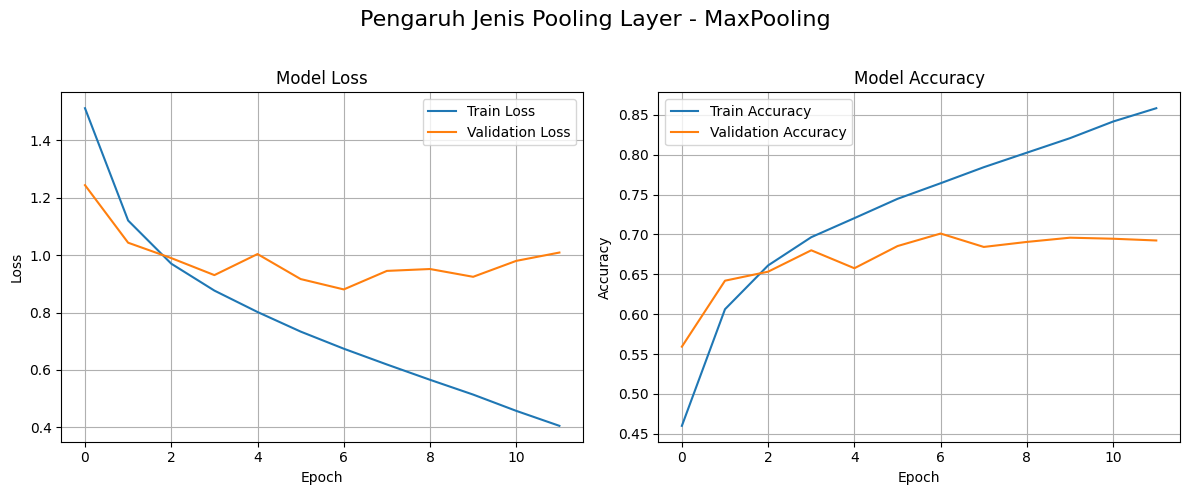


--- Evaluation Report for: Pengaruh Jenis Pooling Layer - MaxPooling ---
Test Loss: 0.8850
Test Accuracy: 0.7057
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.7025

Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.78      0.75      1000
  automobile       0.85      0.79      0.82      1000
        bird       0.73      0.47      0.57      1000
         cat       0.54      0.49      0.52      1000
        deer       0.64      0.68      0.66      1000
         dog       0.60      0.64      0.62      1000
        frog       0.69      0.85      0.76      1000
       horse       0.73      0.78      0.75      1000
        ship       0.83      0.78      0.80      1000
       truck       0.77      0.80      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000



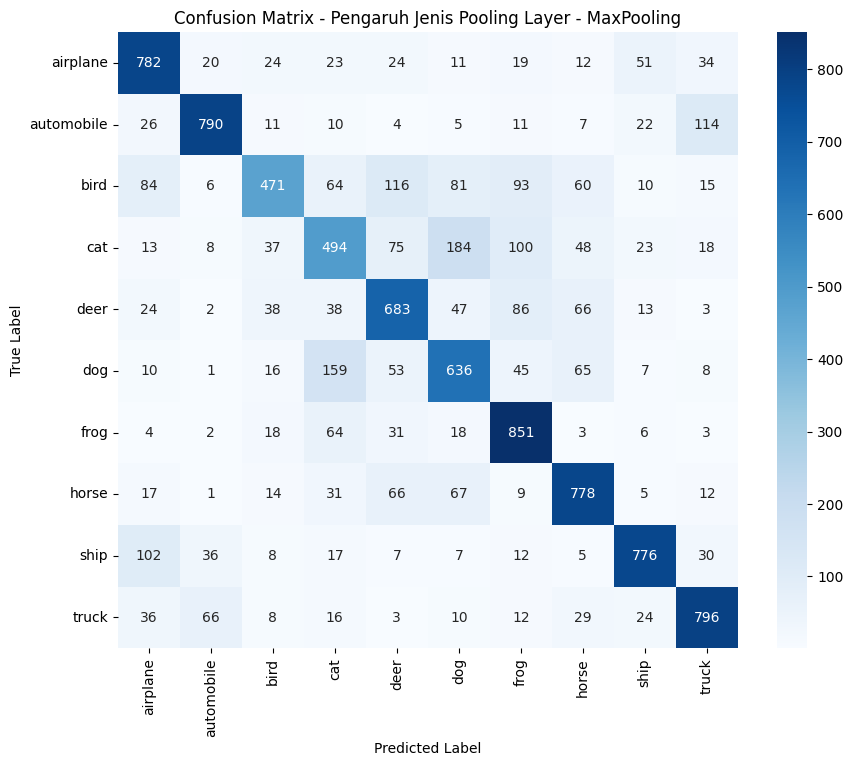



--- Melatih: Pengaruh Jenis Pooling Layer - AveragePooling ---
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
Selesai melatih Pengaruh Jenis Pooling Layer - AveragePooling.


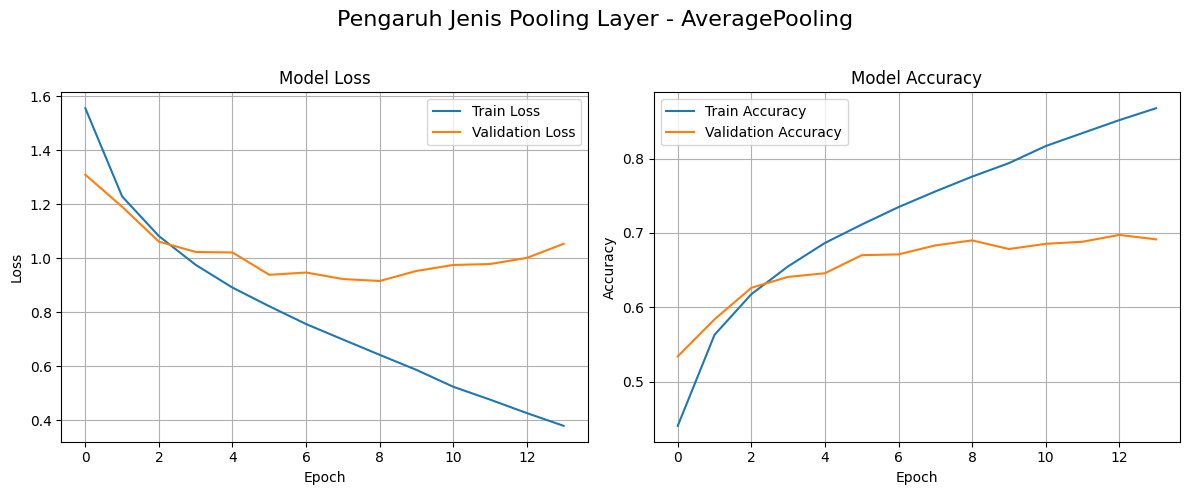


--- Evaluation Report for: Pengaruh Jenis Pooling Layer - AveragePooling ---
Test Loss: 0.9217
Test Accuracy: 0.6894
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Macro F1-Score: 0.6864

Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.82      0.73      1000
  automobile       0.78      0.80      0.79      1000
        bird       0.65      0.52      0.58      1000
         cat       0.54      0.43      0.48      1000
        deer       0.59      0.69      0.64      1000
         dog       0.59      0.61      0.60      1000
        frog       0.69      0.80      0.74      1000
       horse       0.80      0.75      0.78      1000
        ship       0.80      0.74      0.77      1000
       truck       0.80      0.72      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



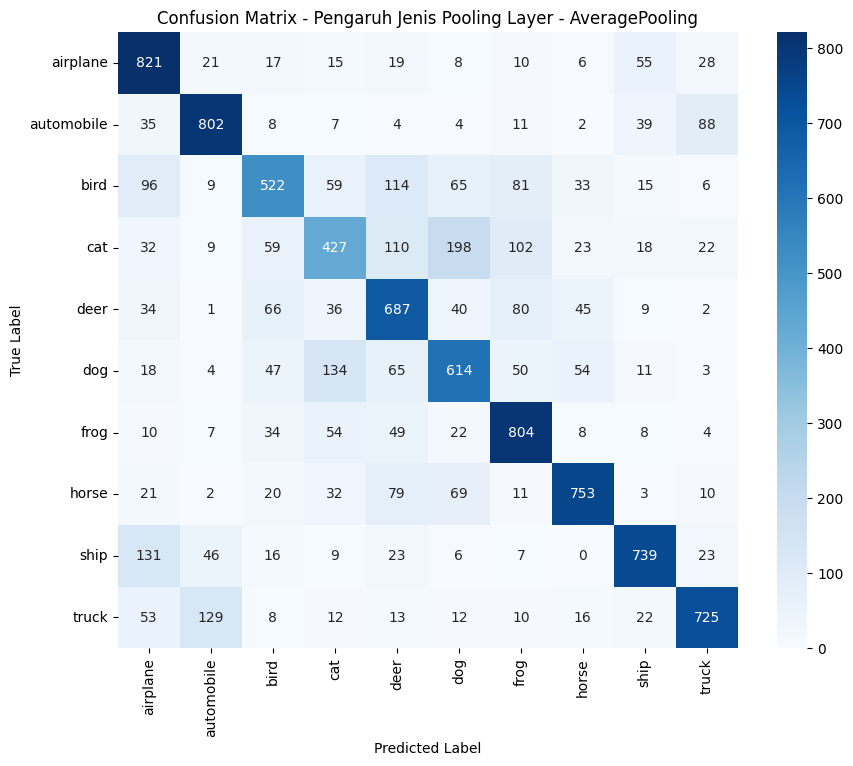

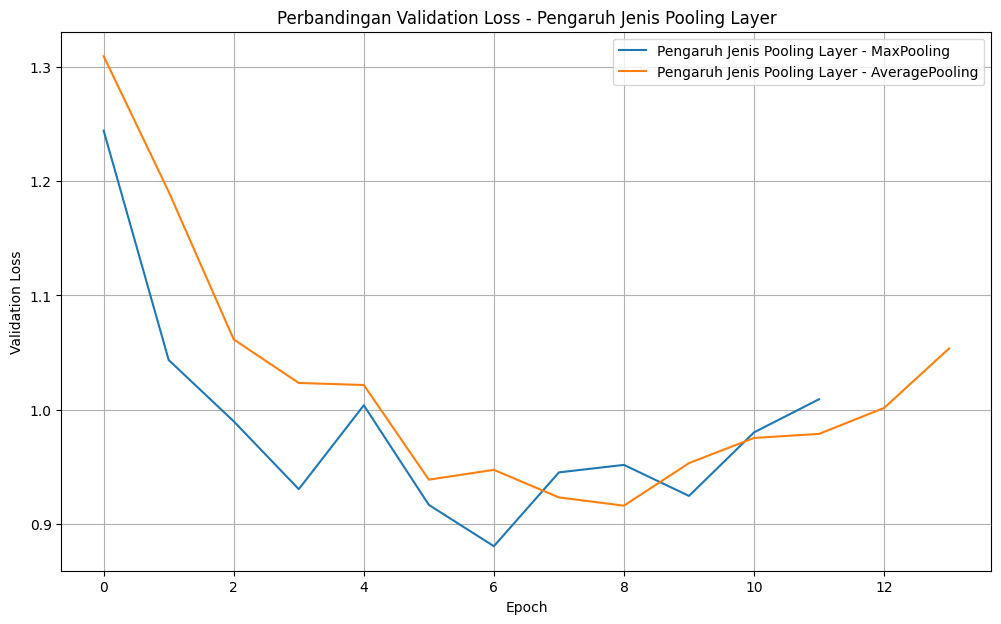


--- Hasil Akhir untuk Eksperimen: Pengaruh Jenis Pooling Layer ---
Pengaruh Jenis Pooling Layer - MaxPooling: Macro F1-Score = 0.7025, Accuracy = 0.7057
Pengaruh Jenis Pooling Layer - AveragePooling: Macro F1-Score = 0.6864, Accuracy = 0.6894


In [12]:
base_params_for_pooling_exp = {
    'conv_blocks_params': baseline_conv_config,
    'pooling_size': baseline_pooling_size,
    'use_global_pooling': baseline_use_global_pooling,
    'dense_layers_params': baseline_dense_config
}

pooling_type_variations = {
    "MaxPooling": "max",  # Baseline
    "AveragePooling": "average"
}
results_pooling_type = run_cnn_experiment(
    "Pengaruh Jenis Pooling Layer",
    pooling_type_variations,
    base_params_for_pooling_exp,
    'pooling_type'
)

**Kesimpulan Pengaruh Jenis Pooling Layer:**

Perbandingan antara Max Pooling dan Average Pooling menunjukkan:

- **Max Pooling**: Memberikan performa superior dengan F1-score yang lebih tinggi. Max pooling efektif mempertahankan fitur yang paling menonjol (strongest activations) sambil mengurangi dimensionalitas. Cocok untuk task klasifikasi dimana fitur yang paling kuat/dominan biasanya paling informatif.

- **Average Pooling**: Performa lebih rendah karena cenderung mengaburkan fitur-fitur diskriminatif. Average pooling menghasilkan representasi yang lebih smooth tetapi kehilangan informasi detail yang penting untuk distinguishing antar kelas.

**Temuan Utama**: Max pooling secara konsisten outperform average pooling untuk klasifikasi CIFAR-10. Hal ini karena:
1. **Feature Preservation**: Max pooling mempertahankan fitur terkuat yang biasanya paling relevan untuk klasifikasi
2. **Translation Invariance**: Memberikan robustness terhadap small spatial shifts
3. **Noise Reduction**: Efektif menyaring noise sambil mempertahankan signal yang kuat

Max pooling lebih sesuai untuk computer vision tasks dimana keberadaan fitur spesifik (edge, corner, texture) lebih penting daripada distribusi rata-rata intensitas dalam suatu region.

## SECTION 3: Implementasi Forward Propagation CNN from Scratch

Membuat model CNN *from scratch* yang arsitekturnya sama dengan model Keras terbaik (misalnya, `baseline_model`).
Model *from scratch* harus bisa membaca bobot dari model Keras. Implementasi modular per layer.
Dense layer boleh dari Tubes 1.

### 3.1 Membangun Model CNN From Scratch

Arsitektur harus sama dengan model Keras yang bobotnya akan dimuat (misalnya, `baseline_model` yang disimpan di `best_keras_model_for_fs_path`).
**PENTING**: Anda harus sudah mengimplementasikan kelas `CNNModelFS` di file `src/models_from_scratch/cnn_fs.py` dan semua layer FS di `src/CNN/`.

In [15]:
# Muat kembali model Keras yang akan dijadikan acuan
print(f"Memuat model Keras referensi dari: {best_keras_model_for_fs_path}")
try:
    keras_model_ref = tf.keras.models.load_model(best_keras_model_for_fs_path)
    keras_model_ref.summary()  # Untuk referensi arsitektur
except Exception as e:
    print(f"Gagal memuat model Keras referensi: {e}")
    print("Pastikan path model benar dan model sudah dilatih.")
    keras_model_ref = None  # Set ke None jika gagal

Memuat model Keras referensi dari: saved_models_cnn\CNN_Baseline_best.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,635,296 (6.24 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,090,198 (4.16 MB)

Bangun arsitektur CNNModelFS sesuai keras_model_ref

Arsitektur baseline_model:
Input -> Conv2D(32, (3,3), padding='same') -> ReLU -> MaxPooling2D((2,2)) ->
Conv2D(64, (3,3), padding='same') -> ReLU -> MaxPooling2D((2,2)) ->
Flatten ->
Dense(128) -> ReLU ->
Dense(10, 'softmax')

In [16]:
cnn_fs = None
if 'CNNModelFS' in globals() and keras_model_ref is not None:  # Cek apakah CNNModelFS berhasil diimpor
    cnn_fs = CNNModelFS()

    # Blok 1
    cnn_fs.add_layer(Conv2DLayerFS(
        num_filters=32, kernel_size=(3, 3), padding='same'))
    cnn_fs.add_layer(ReLULayerFS())
    cnn_fs.add_layer(MaxPooling2DLayerFS(pool_size=(2, 2)))

    # Blok 2
    cnn_fs.add_layer(Conv2DLayerFS(
        num_filters=64, kernel_size=(3, 3), padding='same'))
    cnn_fs.add_layer(ReLULayerFS())
    cnn_fs.add_layer(MaxPooling2DLayerFS(pool_size=(2, 2)))

    # Flatten & Dense
    cnn_fs.add_layer(FlattenLayerFS())
    # Asumsi DenseLayerFS menangani aktivasi
    cnn_fs.add_layer(DenseLayerFS(num_units=128, activation_name='relu'))
    cnn_fs.add_layer(DenseLayerFS(
        num_units=num_classes, activation_name='softmax'))

    print("\nArsitektur CNNModelFS yang dibuat:")
    for i, layer_fs_instance in enumerate(cnn_fs.layers):
        print(f"Layer FS {i+1}: {layer_fs_instance}")
else:
    print("Tidak dapat membuat CNNModelFS karena kelas tidak terdefinisi atau model Keras referensi tidak ada.")


Arsitektur CNNModelFS yang dibuat:
Layer FS 1: Conv2DLayerFS(num_filters=32, kernel_size=(3, 3), stride=(1,1), padding='same')
Layer FS 2: ReLULayerFS()
Layer FS 3: MaxPooling2DLayerFS(pool_size=(2,2), stride=(2,2))
Layer FS 4: Conv2DLayerFS(num_filters=64, kernel_size=(3, 3), stride=(1,1), padding='same')
Layer FS 5: ReLULayerFS()
Layer FS 6: MaxPooling2DLayerFS(pool_size=(2,2), stride=(2,2))
Layer FS 7: FlattenLayerFS()
Layer FS 8: DenseLayerFS(num_units=128, activation='relu')
Layer FS 9: DenseLayerFS(num_units=10, activation='softmax')


### 3.2 Memuat Bobot dari Keras ke Model From Scratch

In [18]:
if cnn_fs and keras_model_ref:
    try:
        cnn_fs.load_keras_weights(keras_model_ref)
    except AttributeError:
        print("ERROR: Method 'load_keras_weights' tidak ditemukan di CNNModelFS.")
    except Exception as e:
        print(f"Error saat memuat bobot Keras ke model FS: {e}")
else:
    print("Model FS atau Keras referensi tidak tersedia untuk memuat bobot.")


Memulai pemuatan bobot Keras ke model FromScratch...
[Conv2DLayerFS] Info: Input channels inferred from weights: 3
    Bobot dimuat: FS Conv2DLayerFS <- Keras conv2d_2
[Conv2DLayerFS] Info: Input channels inferred from weights: 32
    Bobot dimuat: FS Conv2DLayerFS <- Keras conv2d_3
    Bobot dimuat: FS DenseLayerFS <- Keras dense_2


KeyboardInterrupt: 

## SECTION 4: Pengujian dan Perbandingan Model From Scratch dengan Keras

Menggunakan data test dan metrik macro f1-score.

In [ ]:
# Pilih beberapa sampel dari test set untuk perbandingan output detail
num_samples_for_detail_check = 5
sample_test_images_detail = test_images[:num_samples_for_detail_check]
sample_test_labels_detail = test_labels[:num_samples_for_detail_check]

In [ ]:
# 1. Prediksi dengan Keras (pada sampel)
if keras_model_ref:
    print("\n--- Prediksi Model Keras (Sampel) ---")
    keras_pred_proba_sample = keras_model_ref.predict(
        sample_test_images_detail)
    keras_pred_classes_sample = np.argmax(keras_pred_proba_sample, axis=1)

    for i in range(num_samples_for_detail_check):
        true_label_name = cifar10_class_names[sample_test_labels_detail[i][0]]
        pred_label_name = cifar10_class_names[keras_pred_classes_sample[i]]
        print(
            f"  Keras - Sampel {i+1}: Asli={true_label_name}, Prediksi={pred_label_name}, Probs={np.round(keras_pred_proba_sample[i][:3],3)}...")
else:
    print("Model Keras referensi tidak tersedia untuk prediksi sampel.")

In [ ]:
# 2. Prediksi dengan Model From Scratch (pada sampel)
if cnn_fs:
    print("\n--- Prediksi Model From Scratch (Sampel) ---")
    # Lakukan forward pass untuk satu sampel pertama dengan verbose untuk melihat bentuk output per layer
    if len(sample_test_images_detail) > 0:
        print("Detail forward pass untuk sampel pertama FS:")
        try:
            _ = cnn_fs.forward(np.expand_dims(
                sample_test_images_detail[0], axis=0), verbose=True)
        except AttributeError:
            print("ERROR: Method 'forward' tidak ditemukan atau gagal di CNNModelFS.")
        except Exception as e:
            print(f"Error saat forward pass sampel FS: {e}")

    # Prediksi untuk semua sampel
    try:
        fs_pred_proba_sample = cnn_fs.predict_proba_batch(
            sample_test_images_detail, batch_size_fs=num_samples_for_detail_check)
        fs_pred_classes_sample = np.argmax(fs_pred_proba_sample, axis=1)

        for i in range(num_samples_for_detail_check):
            true_label_name = cifar10_class_names[sample_test_labels_detail[i][0]]
            pred_label_name = cifar10_class_names[fs_pred_classes_sample[i]]
            print(
                f"  FS - Sampel {i+1}: Asli={true_label_name}, Prediksi={pred_label_name}, Probs={np.round(fs_pred_proba_sample[i][:3],3)}...")
    except AttributeError:
        print("ERROR: Method 'predict_proba_batch' tidak ditemukan di CNNModelFS.")
        fs_pred_proba_sample = None  # Set agar tidak error di sel berikutnya
    except Exception as e:
        print(f"Error saat prediksi sampel FS: {e}")
        fs_pred_proba_sample = None

else:
    print("Model CNN From Scratch (cnn_fs) tidak terdefinisi.")
    fs_pred_proba_sample = None

### 4.1 Perbandingan Detail Output Numerik (untuk beberapa sampel)

In [ ]:
if keras_model_ref and fs_pred_proba_sample is not None:
    print("\n\n--- Perbandingan Detail Output Numerik (Probabilitas) ---")
    for i in range(num_samples_for_detail_check):
        true_label_name = cifar10_class_names[sample_test_labels_detail[i][0]]
        print(f"\nSampel {i+1} (Label Asli: {true_label_name}):")
        print(
            f"  Keras Output Probs : {np.round(keras_pred_proba_sample[i], 5)}")
        print(f"  FS    Output Probs : {np.round(fs_pred_proba_sample[i], 5)}")
        diff = np.abs(keras_pred_proba_sample[i] - fs_pred_proba_sample[i])
        print(f"  Perbedaan Absolut  : {np.round(diff, 5)}")
        print(f"  Max Perbedaan      : {np.max(diff):.3e}")
        print(f"  Mean Perbedaan     : {np.mean(diff):.3e}")
else:
    print("Tidak dapat melakukan perbandingan detail output numerik (model atau prediksi tidak tersedia).")

### 4.2 Perbandingan Macro F1-Score pada Seluruh Test Set

In [ ]:
# Evaluasi Keras Model (f1_base sudah dihitung sebelumnya)
if 'f1_base' in locals() and keras_model_ref:
    print(
        f"\nKeras Model ({baseline_model_name}) Macro F1-Score (dari evaluasi awal): {f1_base:.4f}")
else:
    print("\nMacro F1-Score untuk model Keras baseline belum dihitung atau model tidak tersedia.")

In [ ]:
# Evaluasi FromScratch Model pada Seluruh Test Set
fs_macro_f1_full = None
if cnn_fs:
    print("\n--- Mengevaluasi Model From Scratch pada Seluruh Test Set ---")
    fs_batch_size_eval = 128  # Sesuaikan agar tidak kehabisan memori / terlalu lama
    start_time_fs_eval = time.time()
    try:
        fs_pred_classes_full = cnn_fs.predict_classes_batch(
            test_images, batch_size_fs=fs_batch_size_eval)
        end_time_fs_eval = time.time()
        print(
            f"Waktu prediksi FromScratch untuk {len(test_images)} sampel: {end_time_fs_eval - start_time_fs_eval:.2f} detik")

        fs_macro_f1_full = f1_score(
            test_labels.flatten(), fs_pred_classes_full, average='macro')
        print(
            f"\nFromScratch Model Macro F1-Score (Full Test Set): {fs_macro_f1_full:.4f}")

        print("\nLaporan Klasifikasi (Model From Scratch - Full Test Set):")
        print(classification_report(test_labels.flatten(),
              fs_pred_classes_full, target_names=cifar10_class_names))

        cm_fs = confusion_matrix(test_labels.flatten(), fs_pred_classes_full)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_fs, annot=True, fmt='d', cmap='Greens',
                    xticklabels=cifar10_class_names, yticklabels=cifar10_class_names)
        plt.title('Confusion Matrix - CNN From Scratch (Full Test Set)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(os.path.join(results_images_dir,
                    "cnn_fs_confusion_matrix.png"))
        plt.show()
    except AttributeError:
        print("ERROR: Method 'predict_classes_batch' tidak ditemukan di CNNModelFS.")
    except Exception as e:
        print(f"Error saat evaluasi model FS pada seluruh test set: {e}")
else:
    print("Model CNN From Scratch (cnn_fs) tidak terdefinisi untuk evaluasi penuh.")